## ENUNCIADO
Realiza un análisis de la información que este contiene. 
A continuación, realiza una tarea de clasificación utilizando para ello dos modelos de clasificación (los que consideres que se ajustan más a las características de los datos). 
Por último, realiza una comparativa y selecciona con cuál de ellos te quedarías como modelo definitivo. Razona todas tus decisiones.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



df_pokes = pd.read_csv('./rsc/pokedex.csv')
display(df_pokes)

print(f'{df_pokes.dtypes}\n')
print('\n')
#Voy a imprimir las columnas que contienen nulos para después valorar que hacer con ellas
for e in df_pokes.columns:
    if df_pokes[e].isnull().any():
        print(f'{e}: {df_pokes[e].isnull().sum()} nulos' )



,pokedex_number,name,attack,defense,height_m,hp,percentage_male,sp_attack,sp_defense,speed,type,weight_kg,generation,is_legendary
0,1,Bulbasaur,49,49,0.7,45,88.1,65,65,45,grass,6.9,1,0
1,2,Ivysaur,62,63,1.0,60,88.1,80,80,60,grass,13.0,1,0
2,3,Venusaur,100,123,2.0,80,88.1,122,120,80,grass,100.0,1,0
3,4,Charmander,52,43,0.6,39,88.1,60,50,65,fire,8.5,1,0
4,5,Charmeleon,64,58,1.1,58,88.1,80,65,80,fire,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,797,Celesteela,101,103,9.2,97,NaN,107,101,61,steel,999.9,7,1
797,798,Kartana,181,131,0.3,59,NaN,59,31,109,grass,0.1,7,1
798,799,Guzzlord,101,53,5.5,223,NaN,97,53,43,dark,888.0,7,1
799,800,Necrozma,107,101,2.4,97,NaN,127,89,79,psychic,230.0,7,1


pokedex_number       int64
name                object
attack               int64
defense              int64
height_m           float64
hp                   int64
percentage_male    float64
sp_attack            int64
sp_defense           int64
speed                int64
type                object
weight_kg          float64
generation           int64
is_legendary         int64
dtype: object



height_m: 20 nulos
percentage_male: 98 nulos
weight_kg: 20 nulos


Estas son las columnas que contienen nulos: 'height_m', 'percentage_male', 'weight_kg'<br>
El porcentaje de género no va a ser relevante en mi clasificación; en cambio el peso y altura puede ser un dato interesante a analizar; voy a dar valor a los valores nulos de altura y peso en base a la media que tengan los pokemon de tu mismo tipo.


In [28]:
# Elimino porcentaje de genero
df_pokes = df_pokes.drop('percentage_male', axis=1)
#display(df_pokes)

#Calculo la media de peso y altura de los tipos de cada pokemon con valor nulo para aplicarla en estos campos nulos
medias = df_pokes.groupby('type')[['height_m', 'weight_kg']].mean()
display(medias)
for i, row in df_pokes.iterrows():
    if pd.isnull(row['height_m']):
        df_pokes.at[i, 'height_m'] = medias.loc[row['type'], 'height_m']
    if pd.isnull(row['weight_kg']):
        df_pokes.at[i, 'weight_kg'] = medias.loc[row['type'], 'weight_kg']

for e in df_pokes.columns:
    if df_pokes[e].isnull().any():
        print(f'{e}: {df_pokes[e].isnull().sum()} nulos')    

,height_m,weight_kg
type,,
bug,0.883333,33.083333
dark,1.296552,69.096552
dragon,1.937037,107.125926
electric,0.981579,37.944737
fairy,0.794444,23.555556
fighting,1.196429,58.675000
fire,1.168000,66.096000
flying,1.166667,52.000000
ghost,1.251852,69.570370


Ya no hay nulos.<br>
Voy a clasificar los pokemon por su poder, sumando todas las estadisticas (atack, sp_atack, defense, sp_defense, speed) para optener la media de sus estadisticas, cuanto mayor sea el sumatorio de sus estadísticas, mayor será el poder del pokemon<br>

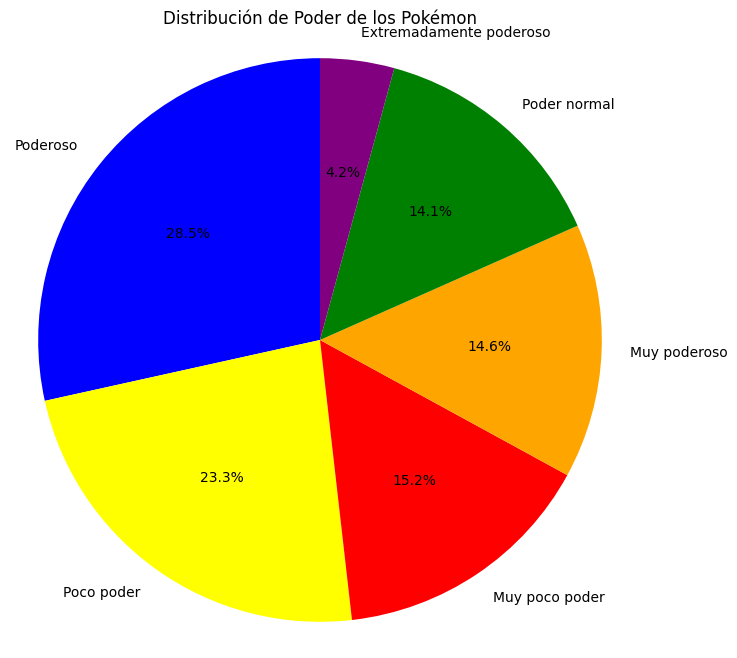

In [29]:
df_pokes['altura_peso'] = df_pokes['height_m'] / df_pokes['weight_kg'] 

df_pokes['stats_media'] = (df_pokes['attack'] + df_pokes['defense'] + df_pokes['sp_attack'] + df_pokes['sp_defense'] + df_pokes['speed']) 
def stats2poder(stats_media):
    if stats_media < 250:
        return 'Muy poco poder'
    elif stats_media < 325:
        return 'Poco poder'
    elif stats_media < 375:
        return 'Poder normal'
    elif stats_media < 450:
        return 'Poderoso'
    elif stats_media < 550:
        return 'Muy poderoso'
    else:
        return 'Extremadamente poderoso'

df_pokes['poder'] = df_pokes['stats_media'].apply(stats2poder)

poder_dict = {
    'Muy poco poder': 0,
    'Poco poder': 1,
    'Poder normal': 2,
    'Poderoso': 3,
    'Muy poderoso': 4,
    'Extremadamente poderoso': 5
}

df_pokes['poder_n'] = df_pokes['poder'].map(poder_dict)

contar_poder = df_pokes['poder'].value_counts()

# Crear el gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(contar_poder, labels=contar_poder.index, autopct='%1.1f%%', startangle=90, colors=['blue','yellow','red','orange','green', 'purple'])
plt.title('Distribución de Poder de los Pokémon')
plt.axis('equal')  # Para que el gráfico de tarta se vea como un círculo perfecto
plt.show()

#pd.set_option('display.max_rows', None)
#print(df_pokes[df_pokes['poder'] == 'Extremadamente poderoso'])


En primer lugar voy a probar a clasificar con el algoritmo KNN:

In [30]:
X = df_pokes[['attack', 'sp_attack', 'altura_peso', 'hp', 'speed', 'sp_defense', 'defense']]
Y = df_pokes[['poder_n']]


scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

n_vecinos = 7   #He realizado varias pruebas y he visto que 7 es el que mayor precisión obtiene
knn = KNeighborsClassifier(n_vecinos) 
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)
print("Accuracy:", knn.score(X_test, Y_test))

Accuracy: 0.8557213930348259


/usr/local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Ahora voy a probar con Random Forest:

In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)

rf.fit(X_train, Y_train)

accuracy = rf.score(X_test, Y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.8159203980099502


/usr/local/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


He probado también con un Árbol de decisión y con una regresión lineal, las he descartado porque los resultados eran mucho peores que los dos modelos anteriores. Dejo el código donde las pruebo:

In [32]:
#Árbol de decisión
tree = DecisionTreeClassifier(random_state=0)

tree.fit(X_train, Y_train)

accuracy = tree.score(X_test, Y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.6417910447761194


In [33]:
#Regresión lineal:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, Y_train)

accuracy = log_reg.score(X_test, Y_test)
print("Accuracy: ", accuracy)

/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7164179104477612


Como se puede observar, los modelos con mejor resultado han sido el 'KNN' con una precisión del 85,5% y el 'Random Forest' con un 81,59% de precisión.